In [12]:
import gymnasium as gym
from gymnasium.wrappers import AtariPreprocessing, FrameStackObservation
import matplotlib.pyplot as plt
import ale_py
from stable_baselines3.common.atari_wrappers import AtariWrapper
import numpy as np

Observation shape: (4, 84, 84)
Action space: Discrete(7)


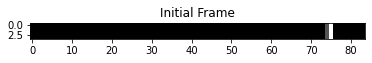

In [27]:
# Calling the environment
env = gym.make("ALE/Assault-v5", render_mode="rgb_array", frameskip=1)

# Using AtariPreprocessing
env = AtariPreprocessing(
    env,
    frame_skip=4,          
    grayscale_obs=True,     
    scale_obs=False,      
    terminal_on_life_loss=False
)

# Stack 4 frames to capture motion
env = FrameStackObservation(env, stack_size=4)

# Testing the environment
obs, info = env.reset()
print("Observation shape:", obs.shape)
print("Action space:", env.action_space)

# Visualizing the first frame
plt.imshow(obs[:, :, 0], cmap="gray")
plt.title("Initial Frame")
plt.show()

# Close the environment
env.close()

### DQN Implementation

In [30]:
# Creating the environment

env = gym.make("ALE/Assault-v5", render_mode="rgb_array")

# Atari Wrapper for handling the environment

env=AtariWrapper(env, frame_skip=4, terminal_on_life_loss=False, clip_reward=True)

# Stacking Images for motion visualization
env = FrameStackObservation(env, stack_size=4)

In [31]:
# Checking how the output looks like

obs, info = env.reset()
print("Observation Shape:", obs.shape)
print("Action Space:", env.action_space)

Observation Shape: (4, 84, 84, 1)
Action Space: Discrete(7)


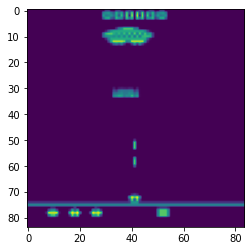

In [19]:
# Visualizing frame

plt.imshow(obs[:,:,0])
plt.show()

Step: Reward=1.0, Terminated=False, Truncated=False


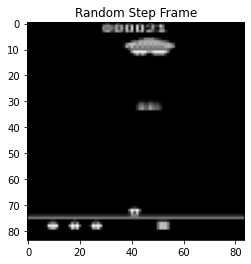

Step: Reward=0.0, Terminated=False, Truncated=False


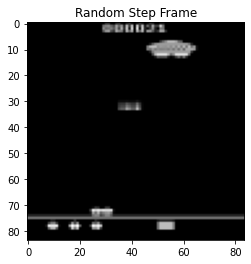

Step: Reward=0.0, Terminated=False, Truncated=False


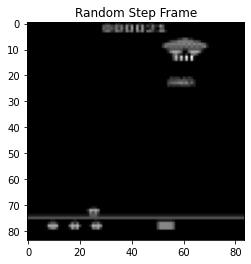

Step: Reward=0.0, Terminated=False, Truncated=False


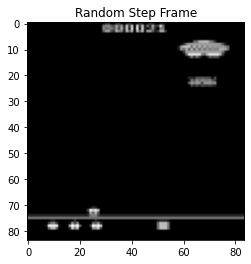

Step: Reward=0.0, Terminated=False, Truncated=False


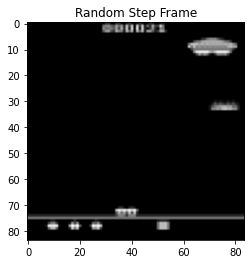

In [20]:
# Taking five random actions and visualizing the environment

for i in range(5):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Step: Reward={reward}, Terminated={terminated}, Truncated={truncated}")
    plt.imshow(obs[:, :, 0], cmap="gray")
    plt.title("Random Step Frame")
    plt.show()
    if terminated or truncated:
        obs, info = env.reset()